(sw_tomography)=

# Part I: Surface-Wave Tomography

Surface-wave tomography commonly relies on the assumption that surface waves propagate along the great-circle path connecting two points on the Earth's surface. This is motivated by the observation that, at the frequency considered, lateral variations in surface-wave velocity are relatively minor, thereby resulting in only slight ray bending. Under this assumption, if we discretize the Earth's surface in $N$ blocks each of constant slowness $s$, the forward equation for the traveltime between two points is $t = \sum_n^N s_n l_n$, where $l$ denotes the length of the great circle crossing the $n$th block.

In the following, we tackle the surface-wave tomography problem using a trans-dimensional discretization of the Earth's surface, via the 2-D Voronoi tessellation as provided by [bayesbay.discretization.Voronoi2D](../api/generated/bayesbay.discretization.Voronoi2D). 

## Import libraries and define constants

In this tutorial, we make use of the [SeisLib](https://seislib.readthedocs.io/en/latest/) Python library; first to generate a synthetic velocity model and then in the forward calculation of surface-wave arrival times.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from seislib.tomography import SeismicTomography
import seislib.colormaps as scm

from bayesbay.discretization import Voronoi2D
from bayesbay.prior import UniformPrior
import bayesbay as bb

np.random.seed(10)

## True velocity model

In [2]:
tomo = SeismicTomography(
    cell_size=0.005, 
    lonmin=-1, 
    lonmax=1, 
    latmin=-1, 
    latmax=1,
    regular_grid=True
    )
grid_points = np.column_stack(tomo.grid.midpoints_lon_lat())
vel_true = tomo.checkerboard(
    ref_value=3, 
    kx=3, 
    ky=3,
    lonmin=tomo.grid.lonmin,
    lonmax=tomo.grid.lonmax,
    latmin=tomo.grid.latmin,
    latmax=tomo.grid.latmax,
    anom_amp=0.3
    )(*grid_points.T)

-------------------------------------
GRID PARAMETERS
Lonmin - Lonmax : -1.000 - 1.000
Latmin - Latmax : -1.000 - 1.000
Number of cells : 160000
Grid cells of 0.005° : 160000
-------------------------------------


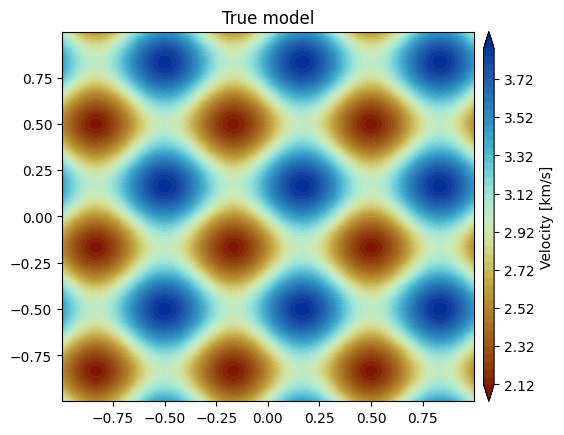

In [3]:
fig, ax = plt.subplots()
img = ax.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax.set_title('True model')
plt.show()

## Observed  Data

In [4]:
def get_sources_and_receivers(n_sources_per_side=10, n_receivers=50):
    ns = n_sources_per_side
    dx = (tomo.grid.lonmax - tomo.grid.lonmin) / ns
    dy = (tomo.grid.latmax - tomo.grid.latmin) / ns
    sources_x = list(np.arange(tomo.grid.lonmin + dx/2, tomo.grid.lonmax, dx))
    sources_y = list(np.arange(tomo.grid.latmin + dy/2, tomo.grid.lonmax, dy))
    sources = np.column_stack((
        [tomo.grid.latmin]*ns + sources_y + [tomo.grid.latmax]*ns + sources_y,
        sources_x + [tomo.grid.lonmax]*ns + sources_x + [tomo.grid.lonmin]*ns
        ))
    receivers = np.random.uniform(
        [tomo.grid.latmin, tomo.grid.lonmin], 
        [tomo.grid.latmax, tomo.grid.lonmax], 
        (n_receivers, 2)
        )
    return sources, receivers

def add_data_coords(tomo, sources, receivers):
    data_coords = np.zeros((sources.shape[0] * receivers.shape[0], 4))
    for icoord, (isource, ireceiver) in enumerate(
            np.ndindex((sources.shape[0], receivers.shape[0]))
            ):
        data_coords[icoord] = np.concatenate(
            (sources[isource], receivers[ireceiver])
            )        
    tomo.data_coords = data_coords

def compute_jacobian(tomo):
    tomo.compile_coefficients()
    jacobian = scipy.sparse.csr_matrix(tomo.A)
    del tomo.A
    return jacobian

    
sources, receivers = get_sources_and_receivers(n_sources_per_side=10, 
                                               n_receivers=50)
add_data_coords(tomo, sources, receivers)
jacobian = compute_jacobian(tomo)
d_obs = jacobian @ (1/vel_true)

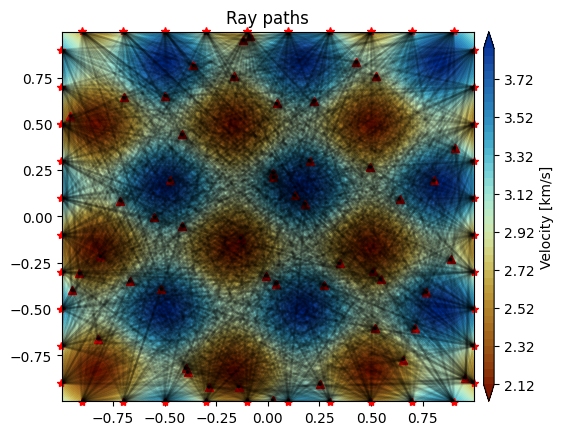

In [12]:
fig, ax = plt.subplots()
img = ax.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
# Sources and receivers cols are lat, lon
ax.plot(sources[:,1], sources[:,0], 'r*', clip_on=False)
ax.plot(receivers[:,1], receivers[:,0], 'r^')
for lat1, lon1, lat2, lon2 in tomo.data_coords:
    ax.plot([lon1, lon2], [lat1, lat2], 'k', alpha=0.1)
ax.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax.set_title('Ray paths')
plt.show()

## Inference parameterization

In [6]:
vel = UniformPrior('vel', vmin=2, vmax=4, perturb_std=0.1)
voronoi = Voronoi2D(
    name='voronoi', 
    vmin=[tomo.grid.lonmin, tomo.grid.latmin], 
    vmax=[tomo.grid.lonmax, tomo.grid.latmax], 
    perturb_std=0.05, 
    n_dimensions_min=50, 
    n_dimensions_max=1500, 
    parameters=[vel], 
    compute_kdtree=True)
parameterization = bb.parameterization.Parameterization(voronoi)

## Log Likelihood

In [7]:
def _forward(kdtree, vel):
    nearest_neighbors = kdtree.query(grid_points)[1]
    interp_vel = vel[nearest_neighbors]
    return interp_vel, jacobian @ (1 / interp_vel)


def forward(state):
    voronoi = state["voronoi"]
    kdtree = voronoi.load_from_cache('kdtree')
    interp_vel, d_pred = _forward(kdtree, voronoi.get_param_values('vel'))
    state.save_to_extra_storage('interp_vel', interp_vel)
    return d_pred

In [8]:
target = bb.Target('d_obs', 
                   d_obs, 
                   std_min=0, 
                   std_max=0.01, 
                   std_perturb_std=0.001,
                   noise_is_correlated=False)
log_likelihood = bb.LogLikelihood(targets=target, fwd_functions=forward)

## Bayesian Inference

In [9]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    log_likelihood=log_likelihood,
    n_chains=20
)
inversion.run(
    sampler=None, 
    n_iterations=75_000, 
    burnin_iterations=25_000, 
    save_every=250, 
    verbose=True,
    print_every=25_000
)

Chain ID: 6
TEMPERATURE: 1
EXPLORED MODELS: 25000
ACCEPTANCE RATE: 7128/25000 (28.51 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 610/3495 (17.45%)
	DeathPerturbation(voronoi): 435/3646 (11.93%)
	NoisePerturbation(d_obs): 181/3619 (5.00%)
	ParamPerturbation(voronoi.discretization): 658/3514 (18.73%)
	ParamPerturbation(voronoi.vel): 5244/10726 (48.89%)
Chain ID: 12
TEMPERATURE: 1
EXPLORED MODELS: 25000
ACCEPTANCE RATE: 5356/25000 (21.42 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 421/3517 (11.97%)
	DeathPerturbation(voronoi): 272/3509 (7.75%)
	NoisePerturbation(d_obs): 192/3625 (5.30%)
	ParamPerturbation(voronoi.discretization): 448/3542 (12.65%)
	ParamPerturbation(voronoi.vel): 4023/10807 (37.23%)
Chain ID: 4
TEMPERATURE: 1
EXPLORED MODELS: 25000
ACCEPTANCE RATE: 6023/25000 (24.09 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 485/3586 (13.52%)
	DeathPerturbation(voronoi): 345/3601 (9.58%)
	NoisePerturbation(d_obs): 196/3570 (5.49%)
	ParamPerturbat

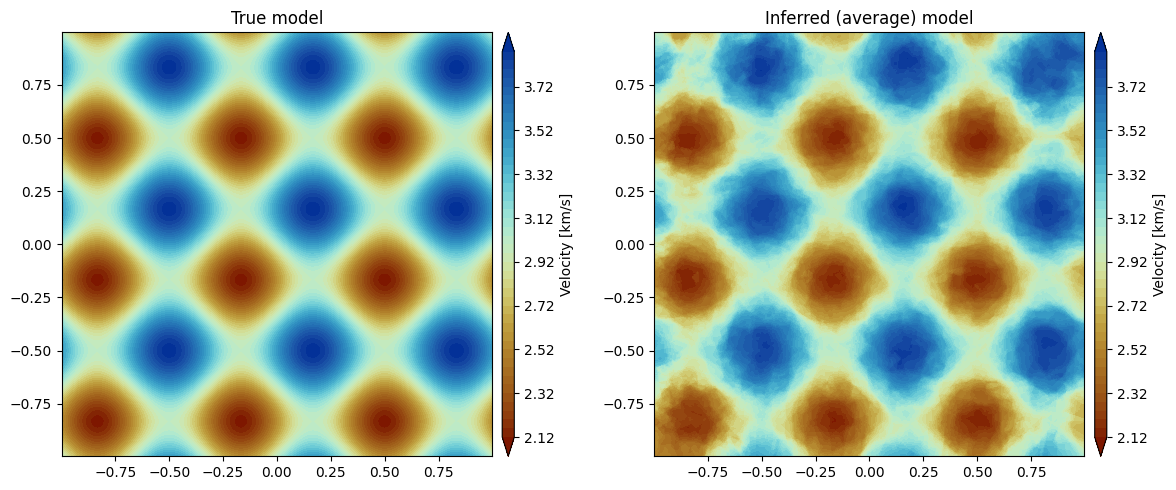

In [11]:
results = inversion.get_results()
inferred_vel = np.mean(results['interp_vel'], axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
img = ax1.tricontourf(*grid_points.T, 
                     vel_true, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax1.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax1.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax1, aspect=35, pad=0.02)
cbar.set_label('Velocity [km/s]')
ax1.set_title('True model')

img = ax2.tricontourf(*grid_points.T, 
                     inferred_vel, 
                     levels=50, 
                     cmap=scm.roma,
                     vmin=vel_true.min(),
                     vmax=vel_true.max(),
                     extend='both')
ax2.set_xlim(grid_points[:,0].min(), grid_points[:,0].max())
ax2.set_ylim(grid_points[:,1].min(), grid_points[:,1].max())
cbar = fig.colorbar(img, ax=ax2, aspect=35, pad=0.02)
ax2.set_title('Inferred (average) model')
cbar.set_label('Velocity [km/s]')

plt.tight_layout()
plt.show()

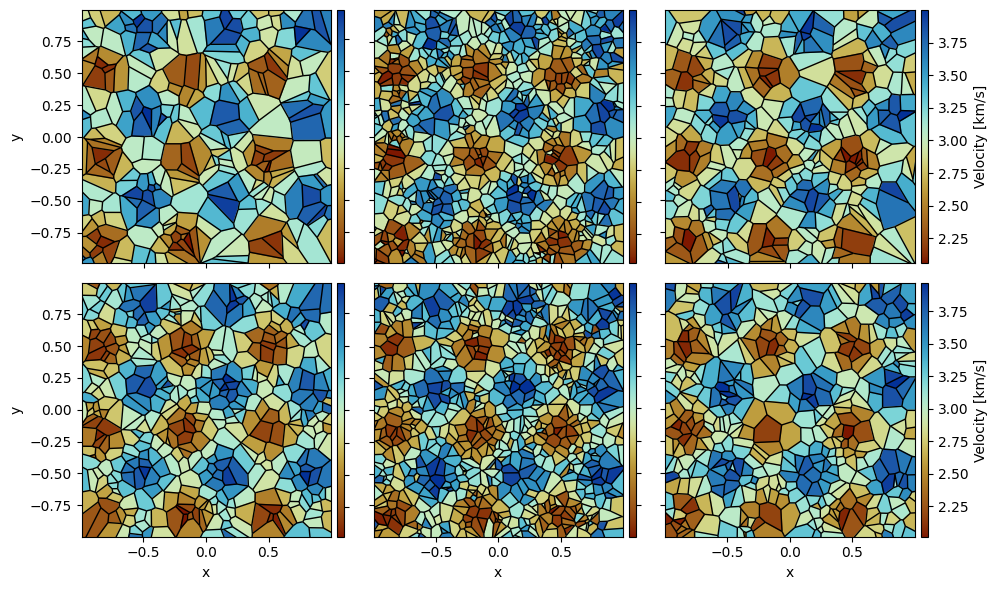

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
random_indexes = np.random.choice(range(len(results['voronoi.vel'])), size=9, replace=False)
for ipanel, (ax, irandom) in enumerate(zip(axes.ravel(), random_indexes)):
    voronoi_sites = results['voronoi.discretization'][irandom]
    velocity = results['voronoi.vel'][irandom]
    ax, cbar = Voronoi2D.plot_tessellation(
        voronoi_sites, 
        velocity, 
        ax=ax, 
        cmap=scm.roma,
        voronoi_sites_kwargs=dict(markersize=0)
    )
    ax.tick_params(labelleft=False, labelbottom=False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    cbar.set_label('Velocity [km/s]')
    if ipanel in [0, 3]:
        ax.tick_params(labelleft=True)
        ax.set_ylabel('y')
    if ipanel not in [2, 5]:
        cbar.set_ticklabels('')
        cbar.set_label('')
    if ipanel>2:
        ax.set_xlabel('x')
        ax.tick_params(labelbottom=True)
plt.tight_layout()
plt.show()